In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [24]:
#read the dataset from dat08mm bucket and the file name is citrus.
df = pd.read_csv('s3://day8mmm/car_data.csv')
df.head()

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0


In [25]:
#laast 5 entry of the dataset
df.tail()

,User ID,Gender,Age,AnnualSalary,Purchased
995,863,Male,38,59000,0
996,800,Female,47,23500,0
997,407,Female,28,138500,1
998,299,Female,48,134000,1
999,687,Female,44,73500,0


In [26]:
#shape means 418 data and the 20 features.
df.shape

(1000, 5)

In [27]:
print(df.dtypes)

User ID          int64
Gender          object
Age              int64
AnnualSalary     int64
Purchased        int64
dtype: object


In [28]:
#check the nullvalues in the dataset
df.isnull().sum()
#so, there are many null vaues in the dataset.

User ID         0
Gender          0
Age             0
AnnualSalary    0
Purchased       0
dtype: int64

In [29]:
df.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [30]:
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0}) 

In [31]:
df.Gender.unique()

array([1, 0])

In [32]:
print(df.dtypes)

User ID         int64
Gender          int64
Age             int64
AnnualSalary    int64
Purchased       int64
dtype: object


In [33]:
df['Gender'].value_counts()

Gender
0    516
1    484
Name: count, dtype: int64

In [34]:
df.nunique().sum()

1297

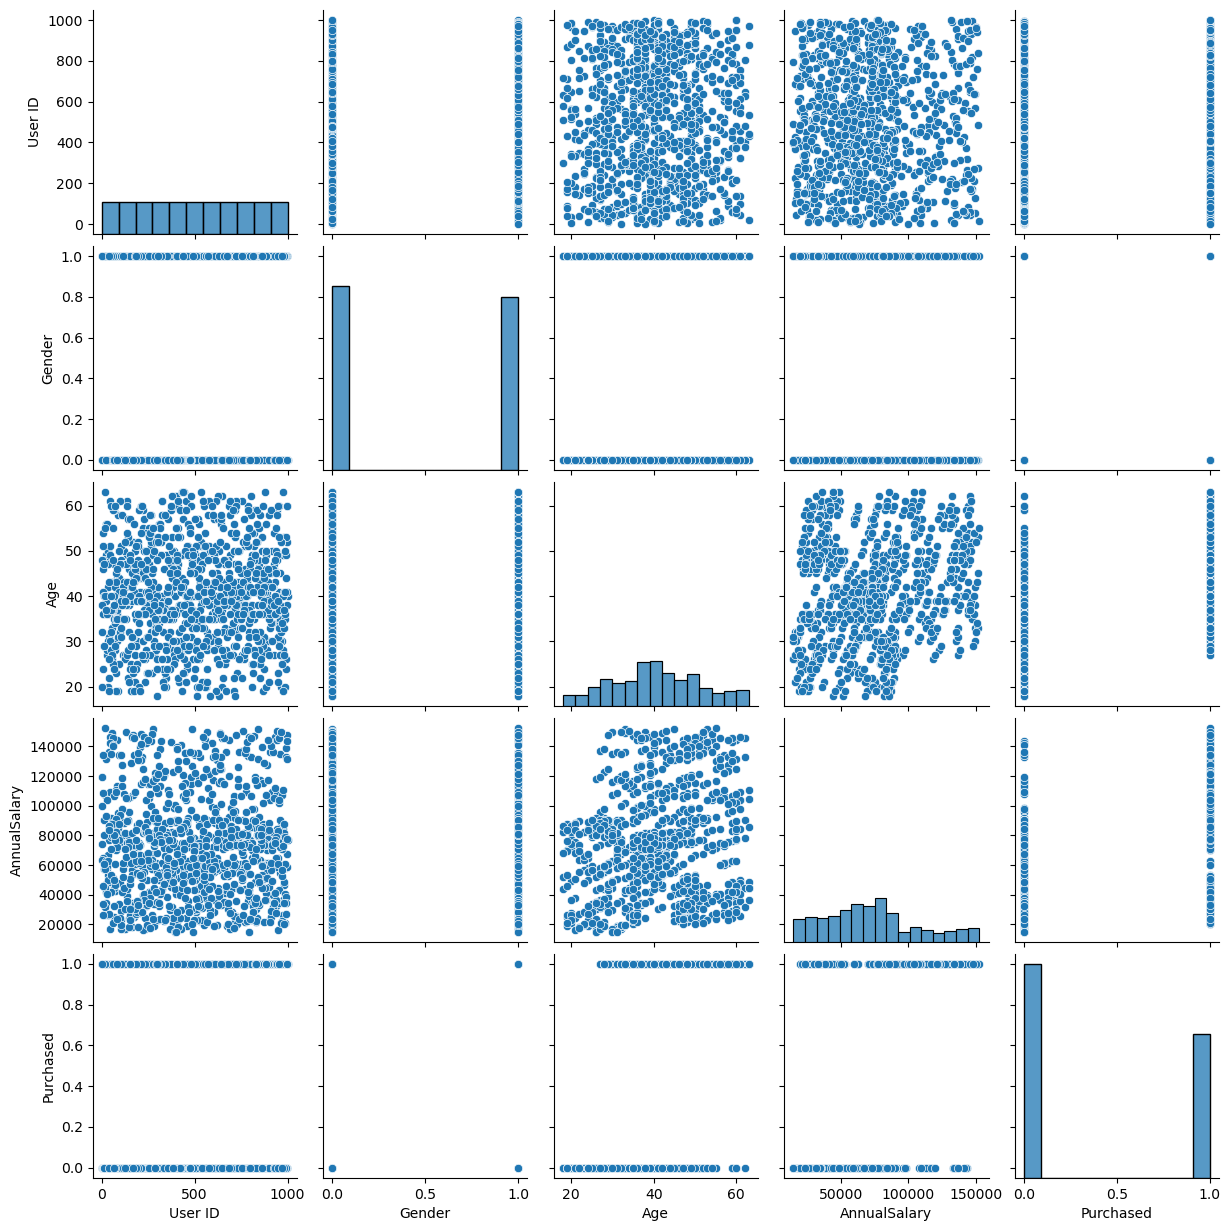

In [35]:
sns.pairplot(df)

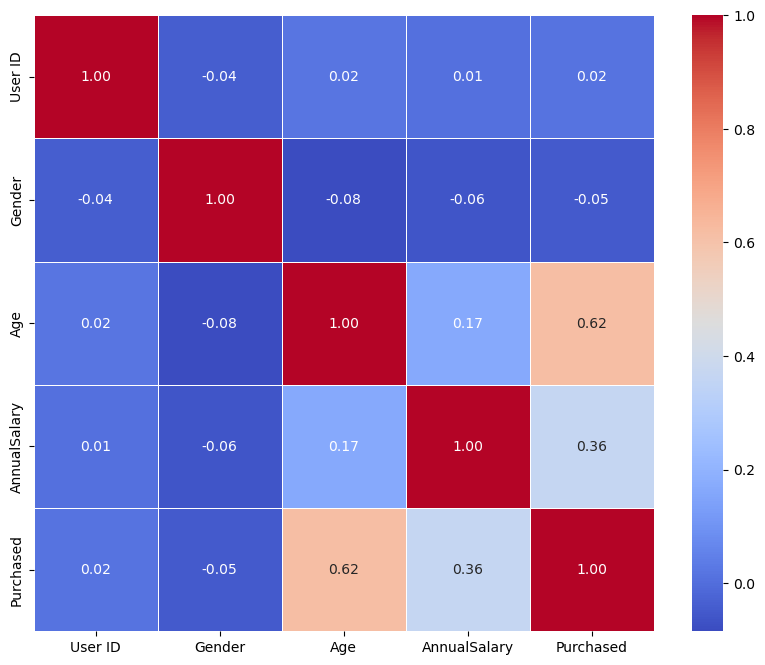

In [37]:

# Assuming your DataFrame is named df
# Convert 'Gender' column to categorical for better visualization
df['Gender'] = df['Gender'].astype('category')

# Create a correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Show the plot
plt.show()



<Axes: xlabel='AnnualSalary', ylabel='Count'>

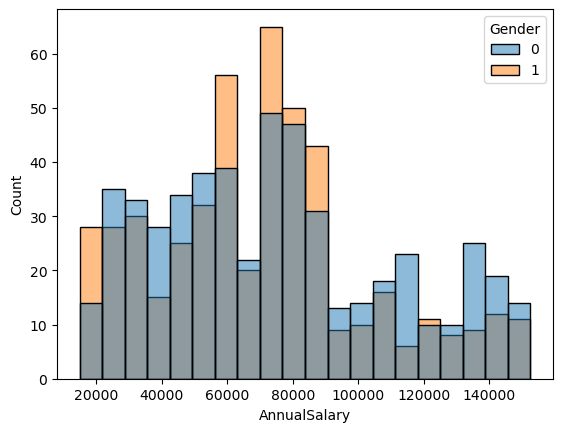

In [38]:
sns.histplot(x='AnnualSalary', data=df, hue='Gender', bins=20)

In [39]:

df = df.drop(['Gender', 'User ID'], axis=1)

In [40]:
df.head()

,Age,AnnualSalary,Purchased
0,35,20000,0
1,40,43500,0
2,49,74000,0
3,40,107500,1
4,25,79000,0


In [41]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [42]:
import os
import boto3
import re
import sagemaker

role = sagemaker.get_execution_role()   # execution role
region = boto3.Session().region_name    # region name
smclient = boto3.Session().client("sagemaker")    # setting sagemaker session 
bucket = "day8mmm"
prefix = ("carpurchase") # place to upload training files within the bucket
print (region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
us-east-1


In [43]:
#split the dataset in to 70% traning 20 validation and 10 for the testing
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729),[int(0.7 * len(df)), int(0.9 * len(df))])

pd.concat([train_data["Purchased"], train_data.drop(["Purchased"], axis=1)], axis=1).to_csv("train.csv", index=False, header=False
)  
pd.concat([validation_data["Purchased"], validation_data.drop(["Purchased"], axis=1)], axis=1).to_csv("validation.csv", index=False, header=False)
pd.concat([test_data["Purchased"], test_data.drop(["Purchased"], axis=1)], axis=1).to_csv("test.csv", index=False, header=False
)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [44]:
train_y = train_data["Purchased"]
train_X = train_data.drop(["Purchased"], axis=1)
test_y = test_data["Purchased"]
test_X = test_data.drop(["Purchased"], axis=1)



In [45]:
# uploading train and validation in s3 bucket
boto3.Session().resource("s3").Bucket(bucket).Object(
 os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
 os.path.join(prefix, "validation/validation.csv")
).upload_file("validation.csv")

In [47]:

import xgboost as xgb




# Step 1: Train-Test Split
X = df.drop(["Purchased"], axis=1)  # Assuming the target variable is named 'target_column'
y = df["Purchased"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: XGBoost Model Training
xg_cls = xgb.XGBClassifier(objective='binary:logistic', seed=42)
xg_cls.fit(X_train, y_train)

# Step 3: Model Evaluation
y_pred = xg_cls.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.905


In [48]:
from time import gmtime, strftime, sleep

tuning_job_name = "xgboost-tuningjob-" + strftime("%d-%H-%M-%S", gmtime())   # generating unique hyperaparameter tuning job name
print(tuning_job_name)

# configuration for the hyperparameter tuning job
tuning_job_config = {
    "ParameterRanges": {
        "CategoricalParameterRanges": [],
        "ContinuousParameterRanges": [
            {
                "MaxValue": "1",
                "MinValue": "0",
                "Name": "eta",      # Learning rate parameter
            },
            {
                "MaxValue": "10",
                "MinValue": "1",
                "Name": "min_child_weight",    # Minimum sum of instance weight in a child
            },
            {
                "MaxValue": "2",
                "MinValue": "0",
                "Name": "alpha",    # # L1 regularization term
            },
        ],
        "IntegerParameterRanges": [
            {
                "MaxValue": "10",
                "MinValue": "1",
                "Name": "max_depth",    # Maximum depth of a tree
            }
        ],
    },
    "ResourceLimits": {"MaxNumberOfTrainingJobs": 10, "MaxParallelTrainingJobs": 3},
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {"MetricName": "validation:accuracy", "Type": "Maximize"},
}

xgboost-tuningjob-29-09-32-42


In [49]:
from sagemaker.image_uris import retrieve

training_image = retrieve(framework="xgboost", region=region, version="1.5-1")    # Retrieving the URI of the pre-built Docker image for XGBoost

# S3 input paths for training and validation data
s3_input_train = "s3://{}/{}/train".format(bucket, prefix)
s3_input_validation = "s3://{}/{}/validation/".format(bucket, prefix)

# configuration for the SageMaker training job
training_job_definition = {
    "AlgorithmSpecification": {"TrainingImage": training_image, "TrainingInputMode": "File"},    # algorithm and its training image
    "InputDataConfig": [    # input data configuration for training and validation
        {
            "ChannelName": "train",    # Channel name for training data
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_train,    # S3 path for training data
                }
            },
        },
        {
            "ChannelName": "validation",    # Channel name for validation data
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_validation,   # S3 path for validation data
                }
            },
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/output".format(bucket, prefix)},    # output data configuration for storing model artifacts
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m4.xlarge", "VolumeSizeInGB": 10},    # resource configuration for training instances
    "RoleArn": role,   # IAM role 
    "StaticHyperParameters": {    # static hyperparameters for the XGBoost algorithm
        "eval_metric": "auc",
        "num_round": "100",
        "objective": "binary:logistic",
        "rate_drop": "0.3",
        "tweedie_variance_power": "1.4",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 43200},    #  stopping conditions for the training job
}

In [50]:
# creating the hyperparameter tuning job
smclient.create_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    HyperParameterTuningJobConfig=tuning_job_config,
    TrainingJobDefinition=training_job_definition,
)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:263245924849:hyper-parameter-tuning-job/xgboost-tuningjob-29-09-32-42',
 'ResponseMetadata': {'RequestId': '1179d2c5-25d2-4d05-b517-1cb497a402dc',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '1179d2c5-25d2-4d05-b517-1cb497a402dc',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '130',
   'date': 'Wed, 29 Nov 2023 09:33:34 GMT'},
  'RetryAttempts': 0}}

In [52]:
# status of hp
smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)["HyperParameterTuningJobStatus"]

'InProgress'

In [53]:
# Job name of hp
smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobName']

'xgboost-tuningjob-29-09-32-42'

In [54]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

objective = tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]
is_minimize = objective["Type"] != "Maximize"
objective_name = objective["MetricName"]

10 training jobs have completed


In [55]:
from pprint import pprint
# extracting best training job from the rest
if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2023, 11, 29, 9, 33, 43, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:accuracy',
                                                 'Value': 0.8999999761581421},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2023, 11, 29, 9, 37, 47, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:263245924849:training-job/xgboost-tuningjob-29-09-32-42-003-98ef8cbe',
 'TrainingJobName': 'xgboost-tuningjob-29-09-32-42-003-98ef8cbe',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2023, 11, 29, 9, 35, 50, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '0.3278864921358766',
                          'eta': '0.9129240163757562',
                          'max_depth': '9',
                          'min_child_weight': '7.931497289476176'}}


In [56]:
# Now training the model with the best hp values
xgboost_job = "xgboost-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Job name is:", xgboost_job)

s3_input_train = "s3://{}/{}/train".format(bucket, prefix)
s3_input_validation = "s3://{}/{}/validation/".format(bucket, prefix)

training_job_definition = {
    "RoleArn": role,
    "TrainingJobName": xgboost_job,
    "AlgorithmSpecification": {"TrainingImage": training_image, "TrainingInputMode": "File"},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_train,
                }
            },
        },
        {
            "ChannelName": "validation",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_validation,
                }
            },
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/output".format(bucket, prefix)},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m4.xlarge", "VolumeSizeInGB": 10},
    "RoleArn": role,
    "HyperParameters": {
        "eval_metric": "auc",
        "num_round": "100",
        "objective": "binary:logistic",
        "rate_drop": "0.3",
        "tweedie_variance_power": "1.4",
        'alpha': '0.3278864921358766',
         'eta': '0.9129240163757562',
        'max_depth': '9',
       'min_child_weight': '7.931497289476176'
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 43200},
}

Job name is: xgboost-2023-11-29-09-43-21


In [57]:
sm = boto3.client("sagemaker")
sm.create_training_job(**training_job_definition)
# checking the status of training
status = sm.describe_training_job(TrainingJobName=xgboost_job)["TrainingJobStatus"]
print(status)
sm.get_waiter("training_job_completed_or_stopped").wait(TrainingJobName=xgboost_job)
if status == "Failed":
    message = sm.describe_training_job(TrainingJobName=xgboost_job)["FailureReason"]
    print("Training failed with the following error: {}".format(message))
    raise Exception("Training job failed")

InProgress


In [58]:
# creating a model using the specified configuration.
xgboost_hosting_container = {
    "Image": training_image,
    "ModelDataUrl": sm.describe_training_job(TrainingJobName=xgboost_job)["ModelArtifacts"][
        "S3ModelArtifacts"
    ],
}

create_model_response = sm.create_model(
    ModelName=xgboost_job, ExecutionRoleArn=role, PrimaryContainer=xgboost_hosting_container
)

print(create_model_response["ModelArn"])

arn:aws:sagemaker:us-east-1:263245924849:model/xgboost-2023-11-29-09-43-21


In [59]:
# configuring endpoint with unique name based on current time
xgboost_endpoint_config = "xgboost-endpoint-config-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(xgboost_endpoint_config)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=xgboost_endpoint_config,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": xgboost_job,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

xgboost-endpoint-config-2023-11-29-09-47-57
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:263245924849:endpoint-config/xgboost-endpoint-config-2023-11-29-09-47-57


In [60]:
%%time

# configuring, creating, waiting and then checking the status again of an endpoint
xgboost_endpoint = "xgboost-endpoint-" + strftime("%Y%m%d%H%M", gmtime())
print(xgboost_endpoint)
create_endpoint_response = sm.create_endpoint(
    EndpointName=xgboost_endpoint, EndpointConfigName=xgboost_endpoint_config
)
print(create_endpoint_response["EndpointArn"])

resp = sm.describe_endpoint(EndpointName=xgboost_endpoint)
status = resp["EndpointStatus"]
print("Status: " + status)

sm.get_waiter("endpoint_in_service").wait(EndpointName=xgboost_endpoint)

resp = sm.describe_endpoint(EndpointName=xgboost_endpoint)
status = resp["EndpointStatus"]
print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

if status != "InService":
    raise Exception("Endpoint creation did not succeed")

xgboost-endpoint-202311290948
arn:aws:sagemaker:us-east-1:263245924849:endpoint/xgboost-endpoint-202311290948
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:263245924849:endpoint/xgboost-endpoint-202311290948
Status: InService
CPU times: user 75.2 ms, sys: 2.65 ms, total: 77.8 ms
Wall time: 4min 1s


In [61]:
def np2csv(arr):
    csv = io.BytesIO() #the function gets an array (Numpy array) and creates an in-memory binary buffer named csv
    np.savetxt(csv, arr, delimiter=",", fmt="%g") # write the array 'arr' to csv object, columns should be seperated by commas. The fmt="%g" removes unneccesary decimals when saving and use scientific notation.
    # In the following line:
    # csv.getvalue() retrieves the entire contents of the buffer csv as a byte string.
    # .decode() converts the byte string into a normal Python string by decoding it using the default UTF-8 encoding.
    #.rstrip() removes any trailing whitespace or newlines from the end of the string.
    return csv.getvalue().decode().rstrip()

In [62]:
import io, json
runtime = boto3.client("runtime.sagemaker")

payload = np2csv(test_X)

# invoking endpoint which is used to make a prediction request to the SageMaker endpoint.
response = runtime.invoke_endpoint(
    EndpointName=xgboost_endpoint, ContentType="text/csv", Body=payload
)
result = response["Body"].read().decode()
test_pred = np.array(result.split(), dtype=float)
#The following line:
# extracts the prediction results from the result dictionary, from the "predictions" key.
# It is a list of dictionaries where each dictionary has a key "score" representing the model's prediction. 

In [63]:
print(test_pred)

[0.0012802  0.93373996 0.94118923 0.95290178 0.00167759 0.06570318
 0.00167759 0.97376966 0.01045565 0.00676748 0.93719411 0.0059403
 0.00456492 0.00687622 0.90782923 0.00676748 0.97376966 0.0813053
 0.02758263 0.01757887 0.988841   0.00167759 0.99747002 0.00288753
 0.02194674 0.06394147 0.94989216 0.04408028 0.93373996 0.6252721
 0.99398732 0.00159573 0.79540849 0.0813053  0.02311361 0.00171752
 0.02508585 0.84586787 0.42848656 0.15490961 0.00159573 0.00163485
 0.00148867 0.00442019 0.00167759 0.00686257 0.00391259 0.90275007
 0.00686257 0.97790754 0.00676748 0.49416673 0.29555649 0.1636572
 0.9944706  0.00658557 0.00159573 0.01858711 0.67941684 0.9199627
 0.38998181 0.00250303 0.00158208 0.01152514 0.96172732 0.42499021
 0.94096947 0.61529714 0.95145559 0.48768187 0.30007827 0.05523231
 0.97506082 0.9033953  0.19734618 0.99088556 0.00167759 0.79540849
 0.24968146 0.00167759 0.93373996 0.60703546 0.64508146 0.00167759
 0.01919738 0.9033953  0.00288753 0.00520179 0.00167759 0.79540849


Accuracy: 0.8900
ROC AUC: 0.9541


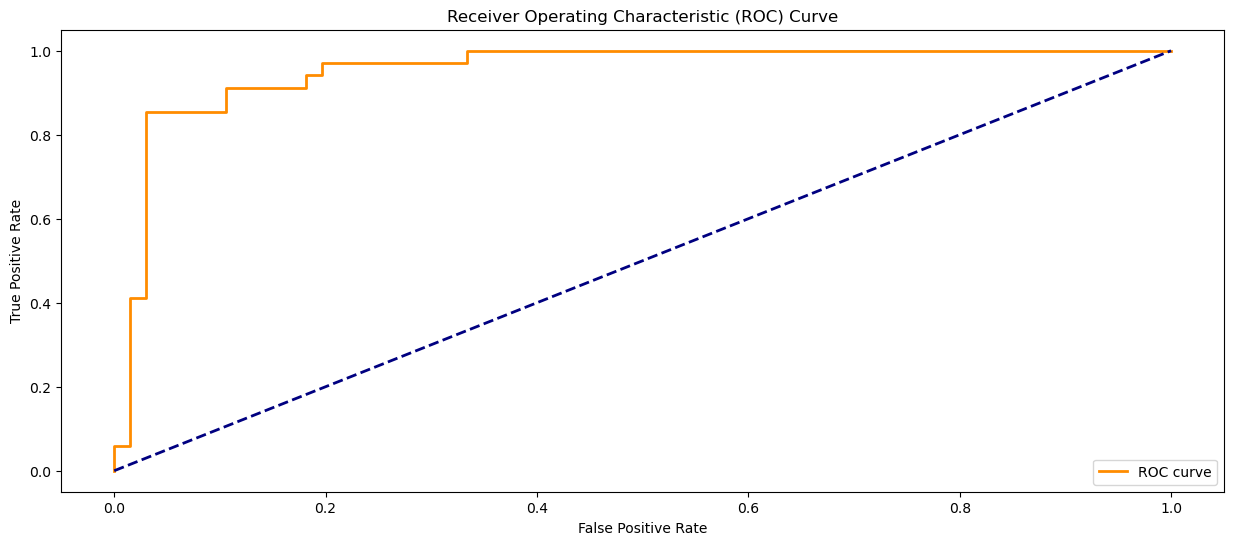

Confusion Matrix:
[[59  7]
 [ 4 30]]


In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Assuming test_y and test_pred are your true labels and predicted probabilities

# Convert probabilities to binary predictions (0 or 1)
test_pred_class = (test_pred > 0.5).astype(int)

# Calculate and print accuracy
accuracy = accuracy_score(test_y, test_pred_class)
print(f'Accuracy: {accuracy:.4f}')

# Calculate and print ROC AUC
roc_auc = roc_auc_score(test_y, test_pred)
print(f'ROC AUC: {roc_auc:.4f}')

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_y, test_pred)
plt.figure(figsize=(15, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print confusion matrix
conf_matrix = confusion_matrix(test_y, test_pred_class)
print('Confusion Matrix:')
print(conf_matrix)

In [71]:
import xgboost as xgb




# Step 1: Train-Test Split
X = df.drop(["Purchased"], axis=1)  # Assuming the target variable is named 'target_column'
y = df["Purchased"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: XGBoost Model Training
xg_cls = xgb.XGBClassifier(objective='binary:logistic', seed=42)
xg_cls.fit(X_train, y_train)

# Step 3: Model Evaluation
y_pred = xg_cls.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.905


In [68]:
sm.delete_endpoint(EndpointName=xgboost_endpoint)

{'ResponseMetadata': {'RequestId': '517128dc-bc32-4dc8-adf9-0c7a7960eede',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '517128dc-bc32-4dc8-adf9-0c7a7960eede',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 29 Nov 2023 09:54:24 GMT'},
  'RetryAttempts': 0}}